## Bayesian Optimization with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a Gradient Boosting Classifier, using the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).

We will do the search manually, defining the objective function (hyperparameter response function ) and using the [Gaussian Process minimizer class from Scikit-optimize](
https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize).


### Important

Remember that we use **Bayesian Optimization** when we are looking to optimize functions that are costly, like those derived from neuronal networks. For a Gradient Boosting Machine trained on little data like the one in this notebook, we would probably make a better search if we carried out a Random Search.

An example from scikit-optimize to optimize a regression can be found [here](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html#sphx-glr-auto-examples-hyperparameter-optimization-py)


### Hyperparameter Tunning Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- decide which parameters to optimize
- define the objective function we want to minimize.


### NOTE

Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [2]:
# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts(normalize=True)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)

In [5]:
# With Integer, we create a space of integers, sampled uniformly
# between the minimum and maximum indicated values

Integer(10, 120, name="n_estimators")

Integer(low=10, high=120, prior='uniform', transform='identity')

In [16]:
# With Real, we create a space of real values, sampled uniformly
# between the minimum and maximum indicated values

Real(0.001, 1, name="min_samples_split")

Real(low=0.001, high=0.999, prior='uniform', transform='identity')

In [7]:
# With Categorical, we create a space of categories

Categorical(['deviance', 'exponential'], name="loss")

Categorical(categories=('deviance', 'exponential'), prior=None)

In [17]:
# determine the hyperparameter space

param_grid = [
    Integer(10, 120, name="n_estimators"),
    Real(0.001, 1, name="min_samples_split"),
    Integer(1, 5, name="max_depth"),
    Categorical(['deviance', 'exponential'], name="loss"),
]

# Scikit-optimize parameter grid is a list
type(param_grid)

list

## Define the model

In [19]:
# set up the gradient boosting classifier

gbm = GradientBoostingClassifier(random_state=0)

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [20]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

## Bayesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization.

In [21]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=50, # the number of subsequent evaluations of f(x)
    random_state=0,
    n_jobs=-1 
)

In [22]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9724'

In [23]:
print("""Best parameters:
=========================
- n_estimators=%d
- min_samples_split=%.6f
- max_depth=%d
- loss = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- n_estimators=120
- min_samples_split=0.682272
- max_depth=5
- loss = deviance


## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

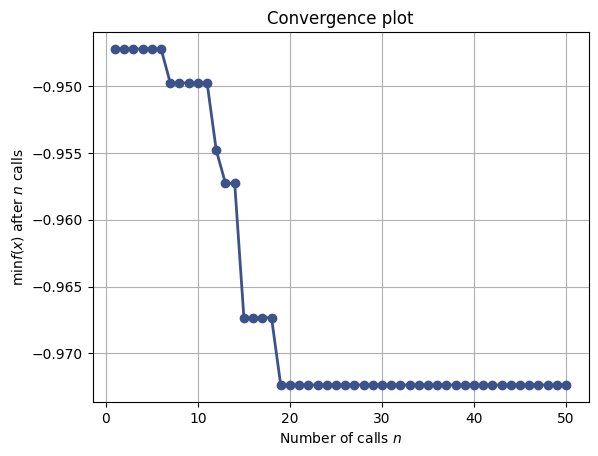

In [24]:
plot_convergence(gp_)

Note that with around 20 iterations, the procedure already found the minimum of the hyperparamter response function.